### Codes

Import necessary libraries to run this model.

In [20]:
!pip install pyswarms
!pip install gitpython

In [21]:
import numpy as np
import folium, itertools, math, pickle, random, time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.image as mpimg
import matplotlib.animation as animation
from os import path
import pyswarms as ps
from pyproj import Proj, transform

import os
os.environ["PROJ_LIB"] = '/opt/conda/envs/python2/share/proj'

In [22]:
import importlib.util
import sys
import requests

# Define the raw URL of the Python files on GitHub
base_url = "https://raw.githubusercontent.com/Asiaban95/changed-QueenAnneFlu/master/"
files = ["Env.py", "Human.py"]

# Function to import a Python module dynamically
def import_module(module_name, file_url):
    response = requests.get(file_url)
    if response.status_code == 200:
        # Define a module object
        module = importlib.util.module_from_spec(importlib.util.spec_from_loader(module_name, loader=None))

        # Execute the code from the response text in the module's namespace
        exec(response.text, module.__dict__)

        # Add the module to the sys.modules dictionary
        sys.modules[module_name] = module
        print(f"fetched Python file {module_name} from the specified URL.")

    else:
        print(f"Failed to fetch Python file {module_name} from the specified URL.")

# Import both Env.py and Human.py modules
for file in files:
    module_name = file.split(".")[0]
    file_url = base_url + file
    import_module(module_name, file_url)

# Now you can use the Env and Human modules
import Env
import Human


fetched Python file Env from the specified URL.
fetched Python file Human from the specified URL.


Import python codes containing the classes and functions for environment and human behaviors.

<a name="data"></a>
## Load (or Find) Your Data

Files of households, workplaces, and schools for the Queen Anne neighborhood are imported.

Choose x and y limits (in UTM) and filter houses to select those in the Queen Anne neighborhood.

In [23]:
# Files of households, workplaces, and schools are imported.
CITY = "QueenAnne" # name of the city you're loading data for
url = 'https://raw.githubusercontent.com/cybergis/QueenAnneFlu/master/data/{}/houses_points.csv'.format(CITY)
url_schools = 'https://raw.githubusercontent.com/cybergis/QueenAnneFlu/master/data/{}/schools_points.csv'.format(CITY)
url_works = 'https://raw.githubusercontent.com/cybergis/QueenAnneFlu/master/data/{}/works_points.csv'.format(CITY)

# Load Houses data
houses = pd.read_csv(url)

# Load schools data
schools = pd.read_csv(url_schools)

# Load works data
works = pd.read_csv(url_works)

# Choose x and y limits (in UTM) and filter houses
xmin = 546302;
xmax = 549610;
ymin = 5274394;
ymax = 5277978;
nhouses_old = len(houses);
houses = houses[(houses.X >= xmin) & (houses.X <= xmax) & (houses.Y >= ymin) & (houses.Y <= ymax)];
nhouses_new = len(houses);
print(nhouses_new," of ",nhouses_old," houses filtered.")

16755  of  391992  houses filtered.


Inspect first five rows of the house, school, and workplace datasets, then create figures to plot the house, school, and workplace datasets.

In [24]:
house_cat = houses.DESCR.unique().tolist() # Obtain the type of households
house_dict = {}
rd_color =["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(len(house_cat))]  # generated random color based on the types of households
for i in range(len(house_cat)):
    houses.loc[houses['DESCR'] == house_cat[i], 'color'] = rd_color[i]   # set value for color column
    house_dict[house_cat[i]] = rd_color[i]
housemyProj = Proj(proj='utm', zone=10, ellps='WGS84', datum='WGS84', units='m')
houselonlat = housemyProj(houses['X'].values.tolist(), houses['Y'].values.tolist(), inverse=True)
houses['lat'] = houselonlat[1]
houses['lon'] = houselonlat[0]
# count the number by house types
for key,value in house_dict.items():
    sub_houses = houses[houses.DESCR == key]
    print("The number of", key, "households is ",len(sub_houses)) # counting the number of houeholds

print("The number of households in total:", len(houses)) # counting the number of households

The number of Multi-Family households is  5282
The number of Single Family households is  11473
The number of households in total: 16755


<ipython-input-24-95dcbb04fe26>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses.loc[houses['DESCR'] == house_cat[i], 'color'] = rd_color[i]   # set value for color column
<ipython-input-24-95dcbb04fe26>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses['lat'] = houselonlat[1]
<ipython-input-24-95dcbb04fe26>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [25]:
school_cat = schools.CODE.unique().tolist() # Obtain the type of schools
school_dict = {}
rd_color =["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(len(school_cat))]   # generate random color based on the types of schools
for i in range(len(school_cat)):
    schools.loc[schools['CODE'] == school_cat[i], 'color'] = rd_color[i]   # set value for color column
    school_dict[school_cat[i]] = rd_color[i]

schoolmyProj = Proj(proj='utm', zone=10, north=True, ellps='WGS84', datum='WGS84', units='m')
schoollonlat = schoolmyProj(schools['X'].values.tolist(), schools['Y'].values.tolist(), inverse=True)
schools['lat'] = schoollonlat[1]
schools['lon'] = schoollonlat[0]
# count the number by school types
for key,value in school_dict.items():
    sub_schools = schools[schools.CODE == key]
    print("The number of", key, "schools is ",len(sub_schools)) # counting the number of schools

print("The number of schools in total:", len(schools)) # counting the number of schools

The number of College or University schools is  13
The number of Elementary schools is  103
The number of High schools is  22
The number of Alternative schools is  24
The number of Junior High/Middle schools is  18
The number of Other Facility schools is  2
The number of K-12 schools is  1
The number of schools in total: 183


In [26]:
work_cat = works.DESCR.unique().tolist() # obtain the type of workplaces
work_dict = {}
rd_color =["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(len(work_cat))]  # generate random color based on the types of workplaces
for i in range(len(work_cat)):
    works.loc[works['DESCR'] == work_cat[i], 'color'] = rd_color[i]   # set value for color column
    work_dict[work_cat[i]] = rd_color[i]

workmyProj = Proj(proj='utm', zone=10, north=True, ellps='WGS84', datum='WGS84', units='m')
worklonlat = workmyProj(works['X'].values.tolist(), works['Y'].values.tolist(), inverse=True)
works['lat'] = worklonlat[1]
works['lon'] = worklonlat[0]
# count the number by workplace types
for key, value in work_dict.items():
    sub_works = works[works.DESCR == key]
    print("The number of", key, "workplace is ",len(sub_works)) # counting the number of schools
print("The number of workplace in total:", len(works)) # counting the number of schools

The number of Commercial/Mixed Use workplace is  15040
The number of Manufacturing/Industrial workplace is  6066
The number of Downtown workplace is  1672
The number of workplace in total: 22778


Before running the simulation, the environments (schools, workplaces, households) and individual human agents needs to be set up. <br>
The functions of _settingSchools ()_, _settingWorks()_, and _settingHouseholds()_ are included in _Env.py_. <br>
The function of _settingHumanAgent()_ is included in _Human.py_.

<a name="synthesize"></a>
## Synthesize a Population

In [27]:
import pickle
import requests
from io import BytesIO

# Function to load or write pickle data
def load_or_write_pickle(url, default_data=None):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            print(f"...loaded data from {url}...")
            return pickle.load(BytesIO(response.content))
    except:
        pass

    print(f"...fetching data from {url}...")
    data = default_data() if callable(default_data) else default_data
    response = requests.get(url)
    if response.status_code == 200:
        with open(BytesIO(response.content), 'wb') as f:
            pickle.dump(data, f)
    return data

# Construct URLs
base_url = 'https://raw.githubusercontent.com/cybergis/QueenAnneFlu/master/data/{}/'
school_url = base_url + 'schoolList.pickle'
work_url = base_url + 'workList.pickle'
house_url = base_url + 'houseList.pickle'
people_url = base_url + 'peopleList.pickle'

# Load or write pickle data
schoolList = load_or_write_pickle(school_url.format(CITY), default_data=lambda: Env.settingSchools(f'./data/{CITY}'))
workList = load_or_write_pickle(work_url.format(CITY), default_data=lambda: Env.settingWorks(f'./data/{CITY}'))
houseList = load_or_write_pickle(house_url.format(CITY), default_data=lambda: Env.settingHouseholds(f'./data/{CITY}', schoolList, workList, houses=houses))
peopleList = load_or_write_pickle(people_url.format(CITY), default_data=lambda: Human.settingHumanAgent(houseList))


...loaded data from https://raw.githubusercontent.com/cybergis/QueenAnneFlu/master/data/QueenAnne/schoolList.pickle...
...loaded data from https://raw.githubusercontent.com/cybergis/QueenAnneFlu/master/data/QueenAnne/workList.pickle...
...loaded data from https://raw.githubusercontent.com/cybergis/QueenAnneFlu/master/data/QueenAnne/houseList.pickle...
...loaded data from https://raw.githubusercontent.com/cybergis/QueenAnneFlu/master/data/QueenAnne/peopleList.pickle...


Inspect the age distribution of the human agents.

Total population: 33648


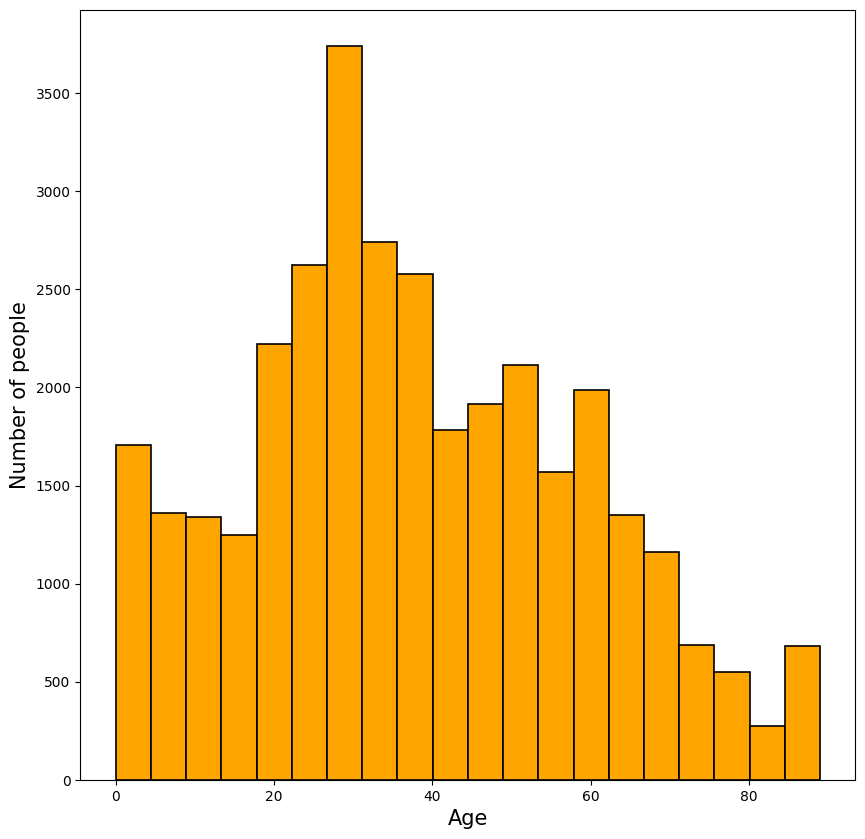

In [28]:
# make a histogram for age distributions of human agents
age = [peopleList[i].age for i in range(0,len(peopleList))] # make a list for people's age
plt.figure(figsize=(10,10))
plt.hist(age, bins=20, color='orange', edgecolor='black', linewidth=1.2)
plt.xlabel("Age", size=15)
plt.ylabel("Number of people", size=15)
print("Total population:", len(peopleList))

### Initial settings of the ABM model

1. introRate: the number of people who are randomized as exposed at the beginning of the simulation.

2. reproduction: the expected average number of secondary infection cases taking place per a single infection case.

3. infRate: the probability that an individual human becomes infectious when he/she contacts an infectious person.

4. days: the duration for the simulation to be run.

_Attention!!!_ Now, this model is assumed to be run for 30 days, but to be fully completed, the days parameter should be 155.

In [29]:
import ipywidgets as widgets
introRateW = widgets.IntSlider(min=0,max=10,value=5, description="introRate")
reproW = widgets.FloatSlider(min=0, max=5, step=0.1,value=2.4, description="reproduction")
infW = widgets.FloatSlider(min=0, max=1, step=.01, value=0.18, description="infRate")
daysW = widgets.IntSlider(min=0, max=155, value = 30, description="days")
display(introRateW, reproW, infW, daysW)

IntSlider(value=5, description='introRate', max=10)

FloatSlider(value=2.4, description='reproduction', max=5.0)

FloatSlider(value=0.18, description='infRate', max=1.0, step=0.01)

IntSlider(value=30, description='days', max=155)

In [30]:
introRate = float(introRateW.value)/10000.0
reproduction = reproW.value
infRate = infW.value
days = daysW.value # the list for counting infectious people over simulation days.

<a name="simulation"></a>
### Processes of the ABM model

1. **for loop** was used to set up simulation perods.
2. During each day, susceptible humans have a chance to be exposed to Influenza by infectious humans.
3. The exposed humans were assumed to become infectious after an incubation period (3 days).
4. The infected humans were assumed to recover after an infectious period (7 days).

In [31]:
from tqdm.notebook import tqdm
def ABMprocess(introRate,reproduction,infRate,days,peopleList,realdata):
  #initial infections based on the introRate
  peopleList = Env.initialInfection(peopleList, introRate)

  total_simulation_time=0
  infectiousCount=[]
  exposedX = []
  exposedY = []
  exposedT = []

  for t in tqdm(range(1,days), desc="Time Steps"):
      start = time.time()
      susceptibleList=[]
      exposedList=[]
      infectiousList=[]
      recoveredList=[]
      for p in tqdm(range(0,len(peopleList)), desc="Update States", leave=False):
          person = peopleList[p]
          person.incubating()
          person.recovering()

          if (person.S==True):
              susceptibleList.append(person)
          if (person.E==True):
              exposedList.append(person)
          if (person.I==True):
              infectiousList.append(person)
          if (person.R==True):
              recoveredList.append(person)
              if (person.recT is None):
                  person.recT = t;
          if (person.infT==t):
              exposedX.append(person.infX)
              exposedY.append(person.infY)
              exposedT.append(person.infT)

      infectiousCount.append(len(infectiousList))

      for p in tqdm(peopleList, desc="Infection", leave=False):
          p.infecting(peopleList, infRate, reproduction, t) #infecting function is included in Human.py

      iteration_time = time.time()-start
      total_simulation_time+=iteration_time
      print("Simulation Day: {:3d},  Remaining Days: {:3d},  # of infectious people: {:5d}  took  {:4.2f} seconds".format(t, days-t,len(exposedList),iteration_time))


  total_simulation_time/=60.0 # get minutes
  hours = False
  daysBool = False
  if total_simulation_time >= 60:
      total_simulation_time/=60.0 # get hours
      hours = True
      if total_simulation_time >= 24:
          total_simulation_time/=24.0
          daysBool = True

  if not (hours and days):
      print("\n\n Total Simulation Time: {:.1f} minutes.".format(total_simulation_time))
  elif not daysBool:
      print("\n\n Total Simulation Time: {:.1f} hours.".format(total_simulation_time))
  else:
      print("\n\n Total Simulation Time: {:.1f} days.".format(total_simulation_time))

  rl=realdata['Positive']
  mae = np.mean(np.abs(infectiousCount-rl))
  return mae

This saves the simulation results to a .csv file to test for stochasticity later. Each time the simulation is run, every function starting with "Synthesize a Population" must be rerun.

In [ ]:
url = 'https://raw.githubusercontent.com/cybergis/QueenAnneFlu/master/data/{}/fludata.csv'.format(CITY)
realdata = pd.read_csv(url)
introRate = 2.36077100e-04
reproduction = 0.92678502
infRate = 6.33373437e-01
days = 22
mae=ABMprocess(introRate,reproduction,infRate,days,peopleList,realdata)
print('MAE is:',mae)

In [ ]:
# @title PSO optimization
# Define the objective function to be optimized
def objective_function(x,**args_dict):
    days = args_dict['days']
    peopleList = args_dict['peopleList']
    realdata = args_dict['realdata']
    result = np.zeros((x.shape[0]))
    for i, subarray in enumerate(x):
      introRate, reproduction, infRate=subarray
      # Call the ABMprocess function with the given input parameters
      result[i] = ABMprocess(introRate,reproduction,infRate,days,peopleList,realdata)
      print(f"\n For particle {i+1}, introRate, reproduction, infRate: {subarray} and Results are: {result[i]}] ")
    # Since pyswarms aims to minimize the objective function, we need to return the negative of the result
    return result

# Define the search space for the input parameters
lb = [0.0, 0.01, 0.01]  # Lower bounds for introRate, reproduction, infRate
ub = [0.001, 5, 1]  # Upper bounds for introRate, reproduction, infRate

args_dict = {
    'days': days,
    'peopleList': peopleList,
    'realdata': realdata
}
# Initialize the optimizer
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=3, options=options, bounds=(lb, ub))

# Perform optimization
best_cost, best_pos = optimizer.optimize(objective_function,30, **args_dict)

print("Optimal introRate, reproduction, infRate:", best_pos)
print("Optimal objective function value:", best_cost)  # Convert back to the original objective function value

In [ ]:
# Access position and cost history
positions_history = optimizer.pos_history
costs_history = optimizer.cost_history

# Print positions and scores for all iterations
for iteration, (positions, costs) in enumerate(zip(positions_history, costs_history), 1):
    print(f"Iteration {iteration}:")
    if isinstance(costs, float):  # Check if costs is a scalar (single float)
        print(f"Particle 1 - Position: {positions}\n , Score: {costs}")
    else:
        for particle_idx, (position, cost) in enumerate(zip(positions, costs), 1):
            print(f"Particle {particle_idx} - Position: {position}\n , Score: {cost}")
